## Import & Description

In [112]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import xgboost as xgb
from scipy.stats import randint, uniform, loguniform

# --- 1. Load Data ---
df = pd.read_csv('UK-HPI-full-file-2024-11.csv')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143820 entries, 0 to 143819
Data columns (total 54 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Date                    143820 non-null  object 
 1   RegionName              143820 non-null  object 
 2   AreaCode                143820 non-null  object 
 3   AveragePrice            143820 non-null  float64
 4   Index                   143820 non-null  float64
 5   IndexSA                 5049 non-null    float64
 6   1m%Change               143396 non-null  float64
 7   12m%Change              139008 non-null  float64
 8   AveragePriceSA          5049 non-null    float64
 9   SalesVolume             139353 non-null  float64
 10  DetachedPrice           137175 non-null  float64
 11  DetachedIndex           137175 non-null  float64
 12  Detached1m%Change       136785 non-null  float64
 13  Detached12m%Change      132519 non-null  float64
 14  SemiDetachedPrice   

,AveragePrice,Index,IndexSA,1m%Change,12m%Change,AveragePriceSA,SalesVolume,DetachedPrice,DetachedIndex,Detached1m%Change,...,NewPrice,NewIndex,New1m%Change,New12m%Change,NewSalesVolume,OldPrice,OldIndex,Old1m%Change,Old12m%Change,OldSalesVolume
count,143820,143820,5049,143396,139008,5049,139353,137175,137175,136785,...,136539,136743,136352,132075,134683,136746,136746,136355,132078,136732
mean,180008,87,89,1,6,168879,1253,319207,88,0,...,214752,88,1,6,136,182005,87,0,6,1137
std,122740,39,36,2,9,88949,7714,280949,37,2,...,127742,38,2,8,846,122490,37,2,9,6963
min,2712,1,18,-30,-36,40405,2,40646,12,-20,...,27230,10,-30,-29,0,22786,10,-31,-30,2
25%,101322,52,65,-0,1,117144,140,173977,58,-0,...,130097,58,-0,2,10,103848,56,-0,1,126
50%,155777,92,93,0,5,157378,216,251871,91,0,...,193526,92,1,6,21,156456,92,0,5,193
75%,227203,114,115,1,10,210861,378,375513,115,1,...,270527,116,2,10,46,227734,113,1,10,344
max,1531416,221,163,35,98,534253,183609,4376492,207,35,...,1303376,235,35,96,21097,1544422,207,36,99,166098


## Data Preprocessing

In [81]:
# --- Basic Cleaning ---
# Converting 'Date' column to datetime format
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y", errors='coerce')
# Dropping rows where Date conversion failed
df.dropna(subset=['Date'], inplace=True)

# Defining key numeric columns to check/convert
key_numeric_cols = [
    'AveragePrice', 'Index', 'SalesVolume',
    'DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 'FlatPrice',
    'CashPrice', 'MortgagePrice', 'FTBPrice', 'FOOPrice', 'NewPrice', 'OldPrice',
    'CashSalesVolume', 'MortgageSalesVolume', 'NewSalesVolume', 'OldSalesVolume'
]

# Ensuring key numeric columns are numeric, coerce errors to NaN
for col in key_numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
print("Key numeric columns converted.")

# --- Feature Engineering ---
# Creating 'Nation' column
df["Nation"] = df["AreaCode"].apply(lambda x:
                                    "England" if str(x).startswith("E") else
                                    "Wales" if str(x).startswith("W") else
                                    "Scotland" if str(x).startswith("S") else
                                    "Northern Ireland" if str(x).startswith("N") else "Unknown")

# ---Sort Data ---
# Sorting by RegionName and Date
df = df.sort_values(by=["RegionName", "Date"]).reset_index(drop=True)

# --- Filter Date Range ---
start_date = '2010-01-01'
end_date = '2023-12-31'
df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].copy() # Use .copy()

# --- Impute Missing Values ---

# Imputing key numeric columns using REGION-SPECIFIC medians
cols_to_impute_grouped = [col for col in key_numeric_cols if col in df_filtered.columns]

for col in cols_to_impute_grouped:
    if df_filtered[col].isnull().any():
        print(f"Imputing '{col}' with regional median...")
        df_filtered[col] = df_filtered.groupby('RegionName')[col]\
                                      .transform(lambda x: x.fillna(x.median()))

# Checking if any NaNs remain in these columns
remaining_na_grouped = df_filtered[cols_to_impute_grouped].isnull().sum()
if remaining_na_grouped.sum() > 0:
    print("Warning: NaNs remaining after grouped imputation. Applying global median as fallback.")
    print(remaining_na_grouped[remaining_na_grouped > 0])
    for col in remaining_na_grouped[remaining_na_grouped > 0].index:
         global_median = df_filtered[col].median()
         df_filtered[col].fillna(global_median, inplace=True)


# Imputing OTHER numeric columns using global median
# Identifying remaining numeric columns that are not in the 'grouped' list
all_numeric_cols = df_filtered.select_dtypes(include=np.number).columns.tolist()
other_numeric_cols = [col for col in all_numeric_cols if col not in cols_to_impute_grouped]

if other_numeric_cols:
    print(f"Imputing other numeric columns with global median: {other_numeric_cols}")
    for col in other_numeric_cols:
        if df_filtered[col].isnull().any():
            median_val = df_filtered[col].median()
            df_filtered[col].fillna(median_val, inplace=True)

# Imputing categorical columns using global mode
print("Imputing categorical columns with global mode...")
cat_cols = df_filtered.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    if df_filtered[col].isnull().any():
        mode_val = df_filtered[col].mode()
        if not mode_val.empty:
            df_filtered[col].fillna(mode_val[0], inplace=True)
        else:
            df_filtered[col].fillna('Unknown', inplace=True) 

# --- Final Checks ---
print("Final check for missing values:")
missing_summary = df_filtered.isnull().sum()
print(missing_summary[missing_summary > 0].to_markdown(numalign="left", stralign="left"))
if missing_summary.sum() == 0:
    print("No missing values remaining.")
else:
    print("Warning: Missing values still present after imputation.")

print("Checking data types:")
print(df_filtered.info())

print("Preprocessing complete. The DataFrame 'df_filtered' is ready.")
df_processed = df_filtered.copy()

Key numeric columns converted.
Imputing 'DetachedPrice' with regional median...
Imputing 'SemiDetachedPrice' with regional median...
Imputing 'TerracedPrice' with regional median...
Imputing 'FlatPrice' with regional median...
Imputing 'CashPrice' with regional median...
Imputing 'MortgagePrice' with regional median...
Imputing 'FTBPrice' with regional median...
Imputing 'FOOPrice' with regional median...
Imputing 'NewPrice' with regional median...
Imputing 'OldPrice' with regional median...
Imputing 'CashSalesVolume' with regional median...
Imputing 'MortgageSalesVolume' with regional median...
Imputing 'NewSalesVolume' with regional median...
Imputing 'OldSalesVolume' with regional median...

DetachedPrice          2016
SemiDetachedPrice      2016
TerracedPrice          1848
FlatPrice              1848
CashPrice              2184
MortgagePrice          2184
FTBPrice               2184
FOOPrice               2184
NewPrice               1848
OldPrice               1848
CashSalesVolume 

In [82]:
df = df_filtered

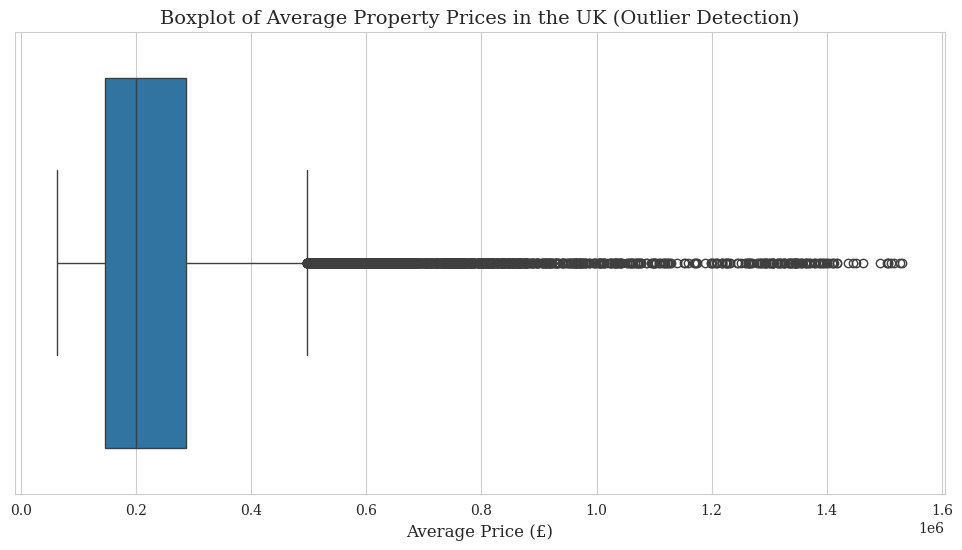

Number of outliers detected in Average Property Price: 947
            Date RegionName  AveragePrice  Z-Score
17722 2013-02-01     Camden        651998        3
17723 2013-03-01     Camden        635099        3
17724 2013-04-01     Camden        649540        3
17725 2013-05-01     Camden        651476        3
17726 2013-06-01     Camden        671439        3


In [83]:
# 1. Checking for Outliers using Boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["AveragePrice"])
plt.title("Boxplot of Average Property Prices in the UK (Outlier Detection)")
plt.xlabel("Average Price (£)")
plt.show()

# 2. Detecting Outliers using Z-score method
outlier_threshold = 3
df["Z-Score"] = np.abs(zscore(df["AveragePrice"]))
outliers = df[df["Z-Score"] > outlier_threshold]

print(f"Number of outliers detected in Average Property Price: {outliers.shape[0]}")
print(outliers[["Date", "RegionName", "AveragePrice", "Z-Score"]].head())

In [84]:
df['ZScore_AvgPrice'] = np.abs(zscore(df['AveragePrice'].dropna()))
outlier_threshold = 3
global_outliers = df[df['ZScore_AvgPrice'] > outlier_threshold]

print(f"Number of global outliers in AveragePrice: {global_outliers.shape[0]}")


Number of global outliers in AveragePrice: 947


In [85]:
window_size = 12
df['RollingMean'] = df['AveragePrice'].rolling(window=window_size, min_periods=1).mean()
df['RollingStd'] = df['AveragePrice'].rolling(window=window_size, min_periods=1).std()

k = 3
df['TimeSeriesOutlier'] = (
    (df['AveragePrice'] > df['RollingMean'] + k * df['RollingStd']) |
    (df['AveragePrice'] < df['RollingMean'] - k * df['RollingStd'])
)

ts_outliers = df[df['TimeSeriesOutlier'] == True]
print(f"Number of time-series outliers: {ts_outliers.shape[0]}")



Number of time-series outliers: 345
